# Building a "large-scale" image search engine

<img src="https://i.imgur.com/rPUaOgO.png" width="600"/>

You and your team are surely on the path to fame and fortune! You have been recruited by Google to disrupt Google Image Search by building a better search engine using novel statistical learning techniques.

The specifications are simple: We need a way to search for relevant images given a natural language query. For instance, if a user types "dog jumping to catch frisbee", your system will rank-order the most relevant images from a large database.

In this tutorial, we provide you with some tools to get you started with this task. We will first do some data exploration and then we will step through the benchmark approach that you have to beat (see [Kaggle](https://www.kaggle.com/c/cs5785-fall-2021-final)). Finally, we will give examples of possible further directions.

**Warning/ Disclaimer:** Proceed with caution. There might be mistakes in this notebook, it is up to you to check every step if you are using these code snippets in your pipeline.

### Summary

* [Data Exploration](#Data-Exploration)
    * [Images](#Images)
    * [Tags](#Tags)
    * [ResNet Feature Vectors](#ResNet-Feature-Vectors)
    * [Descriptions](#Descriptions)
* [Baseline Approach](#Baseline-Approach)
    * [Featurize descriptions](#Featurize-descriptions)
    * [Subsample ResNet features](#Subsample-ResNet-features)
    * [Train and Test](#Train-and-Test)
    * [Submit](#Submit)
* [Further Directions](#Further-Directions)

# Data Exploration

In [1]:
# Some imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import figure

%matplotlib inline

# you might have to tweak the data directory depending on where you downloaded the data
DATA_DIR = "./cs5785-fall-2021-final"

In [2]:
image1 = 2000
image2 = 4567

## Images

Each image has been resized to 224px by 224px.

In [3]:
def show_image(image_index, train_set=True):
    """Display image with given index.
    
    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    image = Image.open(
        os.path.join(DATA_DIR, f'images_{dataset}/{image_index}.jpg'))
    plt.imshow(image)
    plt.show()

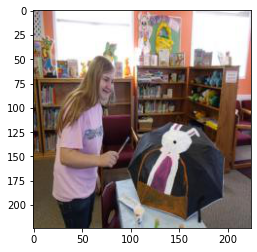

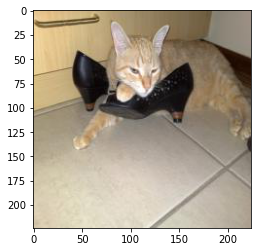

(None, None)

In [4]:
show_image(image1), show_image(image2)

## Tags

Each image has associated tags provided by a human.

In [5]:
def get_tags(image_index, train_set=True):
    """Get tags of image with given index.
    
    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
        
    Returns
    -------
    tags: list of string
        List of tags associated with each image.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    f = open(
        os.path.join(DATA_DIR, f'tags_{dataset}/{image_index}.txt'))
    tags = f.readlines()
    f.close()
    # Some post processing
    tags = [t.strip("\n.") for t in tags]
    return tags

In [6]:
get_tags(image1)

['person:person',
 'accessory:umbrella',
 'indoor:book',
 'furniture:chair',
 'kitchen:cup',
 'indoor:teddy bear']

## ResNet Feature Vectors

Each image has 1000 features provided extracted from the penultimate layer of the pretrained ResNet neural network.

In [7]:
def get_feat_matrix(train_set=True):
    """Get feature matrix for given dataset
    
    Parameters
    ----------
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
        
    Returns
    -------
    X: ndarray of shape (n, 1000)
        A matrix containing the ResNet features for the train or test images.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    feats = pd.read_csv(
        os.path.join(DATA_DIR, f'features_{dataset}/features_resnet1000_{dataset}.csv'),
        names = ['Image']+["X{}".format(i) for i in range(1000)])
    # Need to sort data
    feats["Image"] = feats["Image"].apply(lambda s: int(s.split("/")[1].split(".jpg")[0]))
    feats.sort_values(by="Image", inplace=True)
    X = feats.values[:, 1:]
    return X

In [8]:
X_train = get_feat_matrix()

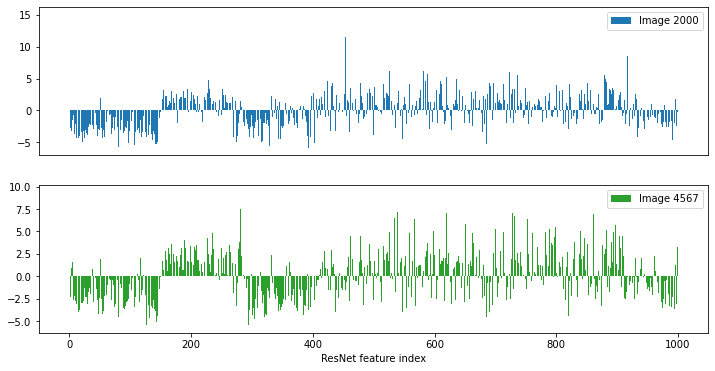

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6))
ax1.bar(np.arange(1000), X_train[image1], label=f"Image {image1}")
ax1.set_xticks([])
ax1.legend()
ax2.bar(np.arange(1000), X_train[image2], label=f"Image {image2}", color='C2')
ax2.legend()
ax2.set_xlabel("ResNet feature index")
plt.show()

## Descriptions 

Each image comes with a series of human given queries (descriptions).

In [10]:
def get_description(image_index, train_set=True):
    """Get description of image with given index.
    
    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
        
    Returns
    -------
    description: string
        The description of the image as a paragraph of text with punctuation removed.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    f = open(
        os.path.join(DATA_DIR, f'descriptions_{dataset}/{image_index}.txt'))
    desc = f.read()
    f.close()
    # Some post-processing 
    desc = desc.replace(".", " ")
    desc = desc.replace("\n", " ")
    return desc

In [11]:
get_description(image2)

'A strawberry blond cat is cuddled up between a pair of ladies business shoes   A cat resting on the floor cuddled up with a pair of heels Orange and white cat laying with its head on some shoes  A very cute orange cat laying with some shoes  a cat rests its head and paw on a pair of womens shoes '

**The Task:** Map descriptions to images (featurized by tags and ResNet features). 

# Baseline approach

This baseline approach combines a language model with the ResNet vision model to map descriptions to images via regression. These are the steps:

1. Featurize the descriptions using the pre-trained [word2vec](https://www.tensorflow.org/tutorials/representation/word2vec) language model. This will serve as your model features $\textbf{X}$. 

2. Subsample the ResNet feature vectors down to 100 features. This will serve as your model target $\textbf{Y}$. 

3. Train a model (i.e. Ridge Regression) that maps $\textbf{X}\rightarrow \textbf{Y}$, i.e. the extracted description features to the subsampled ResNet  features.

4. Use the trained model to find the predicted subsampled ResNet vector. Then find the 20 images in the test set for which the subsampled ResNet vectors are closest to the predicted vector in Euclidian distance. 

In [12]:
# Some preliminaries
# Comment this out after you run it for the first time

# Install packages
!pip install gensim
import gensim

# Download files
import urllib.request
import os
# You can change the path to the downloaded file here
if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
    urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")

## Featurize descriptions

Recall, these will become your features $\textbf{X}$.

In order to featurize the descriptions, we use <a href="https://www.tensorflow.org/tutorials/representation/word2vec">word2vec</a>, which provides a pre-trained 300-dimensional vector representation of most words in the English language. 

We downloaded the word vectors in a file called `GoogleNews-vectors-negative300.bin.gz` from the above link and we will use the <a href="https://radimrehurek.com/gensim/">gensim</a> library in order to access the vectors easily in our code. The feature vector for a given description was then formed by averaging the 300-dimensional word2vec vectors of all the words in the description.

In [13]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

Loaded word vectors successfully!


In [14]:
# Example usage
word2vec.get_vector("carrot").shape

(300,)

In [15]:
train_desc = [get_description(i) for i in range(10000)]
test_desc = [get_description(i, train_set=False) for i in range(2000)]

In [16]:
def doc_to_vec(sentence, word2vec):
    """Convert text to a 300-dimensional vector
    
    Each word is converted to a vector via the word-to-vec model and the vectors are averaged
    to give the final result.
    
    Parameters
    ----------
    sentence: string
        Text to be converted to a vector.
    word2vec: word2vec model
        Movel to be used for vectorization.
        
    Returns
    -------
    vec: array of shape (300, )
        Vector that represents the average of word2vec-transformed vectors for the given sentence. 
    """
    word_vecs = [word2vec.get_vector(w.lower()) for w in sentence.split() if w.lower() in word2vec.key_to_index]
    # Return average
    return np.stack(word_vecs).mean(0)

In [17]:
# Example
doc_to_vec("I love this class!", word2vec)[:10]
doc_to_vec("I love this class!", word2vec).shape

(300,)

In [18]:
X = np.array([doc_to_vec(s, word2vec) for s in train_desc])
X_test = np.array([doc_to_vec(s, word2vec) for s in test_desc])

In [19]:
print("Shape of X:", X.shape)
print("Shape of X_test:", X_test.shape)
print("Done building features!")

Shape of X: (10000, 300)
Shape of X_test: (2000, 300)
Done building features!


## Subsample ResNet features

In order to form the target image vectors for each image we took the 1,000 ResNet and performed a random projection of these features down to 100 dimensions.

In [20]:
# Define a random projection matrix that maps 1000 features to 100 features
np.random.seed(123)
P = np.random.randn(1000, 100)
Y = get_feat_matrix() @ P
Y_test = get_feat_matrix(train_set=False) @ P

In [21]:
print("Shape of Y:", Y.shape)
print("Shape of Y_test:", Y_test.shape)
print("Done building features!")

Shape of Y: (10000, 100)
Shape of Y_test: (2000, 100)
Done building features!


## Train and Test

We train a regularized linear regression model that mapping a 300-dimensional description vector to the 100-dimensional image vector. We used Ridge with cross-validation to select the best regularization coefficient.

Our approach was validated on a held-out development set (randomly selected 20% subset of the training set) so **MAP@20** could be estimated before submitting to Kaggle. However the final model used to generate test predictions for submission was trained on the entire training set.

In [22]:
# Split training data for CV
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=2000, random_state=12345)

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Train OLS model with regression
parameters = {"alpha": [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
reg = GridSearchCV(Ridge(), parameters, cv=10)
reg.fit(X_train, Y_train)
# Note: you might want to do this the AML way
reg_best = reg.best_estimator_

print("Trained linear regression model!")
print("Summary of best model:")
print(reg_best)

Trained linear regression model!
Summary of best model:
Ridge()


In [24]:
# Testing our model

# Map@20
def map_at_20(y_true, y_top_20):
    """Calculate the mean average precision at 20
    
    Parameters
    ----------
    y_true: list of object
        List of the true ID of the image.
        
    y_top_20: ndarray of shape (n, 20)
        List of top 20 IDs predicted for each image.
        
    Returns
    -------
    mean_score: float
        MAP@20 score.
    """
    y_true = np.array(y_true)
    y_top_20 = np.array(y_top_20)
    scores = []
    for i, y_true_i in enumerate(y_true):
        if y_true_i in y_top_20[i]:
            scores.append(1/(np.where(y_top_20[i]==y_true_i)[0][0]+1))
        else:
            scores.append(0)
    return np.mean(scores)
            
# Example
y_true = [1, 2]
y_top_20 = [
    [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
    ]
map_at_20(y_true, y_top_20)

0.041666666666666664

In [25]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

Y_val_pred = reg.predict(X_val)
pw_dist = dist.pairwise(Y_val_pred, Y_val)
print("Pairwise distances shape:", pw_dist.shape)
Y_val_top_20 = [np.argsort(pw_dist[i])[:20] for i in range(len(Y_val_pred))]
Y_val_true = np.arange(2000)

Pairwise distances shape: (2000, 2000)


In [26]:
val_score = map_at_20(Y_val_true, Y_val_top_20)
val_list_pos = [np.where(np.argsort(pw_dist[i])==i)[0][0] for i in range(len(Y_val_pred))]
print("Validation MAP@20:", val_score)
print("Mean index of true image:", np.mean(val_list_pos))
print("Median index of true image:", np.median(val_list_pos))

Validation MAP@20: 0.13067977053046712
Mean index of true image: 91.6975
Median index of true image: 26.0


## Submit

We retrain the regression model on the entire dataset and generate test predictions for the Kaggle submission.

In [27]:
def get_Kaggle_submission(y_top_20):
    """Get data in Kaggle submission format
    
    Parameters
    ----------
    y_top_20: ndarray of shape (n, 20)
        A list of top 20 IDs lists that match each of the n descriptions. 
        
    Returns
    -------
    df: pandas.DataFrame
        Dataframe with columns and values that map correctly to Kaggle's expected submission format.
    """
    d = {
        "Description_ID": [f"{i}.txt" for i in range(len(y_top_20))],
        "Top_20_Image_IDs": [" ".join(
            [f"{j}.jpg" for j in y_top_20[i]]
        ) for i in range(len(y_top_20))]
    }
    return pd.DataFrame(d)

# Retrain on all data
reg_best.fit(X, Y)
Y_test_pred = reg_best.predict(X_test)
pw_dist = dist.pairwise(Y_test_pred, Y_test)
Y_test_top_20 = [np.argsort(pw_dist[i])[:20] for i in range(len(Y_test_pred))]
df_submit = get_Kaggle_submission(Y_test_top_20)

In [28]:
df_submit.head(10)

,Description_ID,Top_20_Image_IDs
0,0.txt,1980.jpg 1480.jpg 629.jpg 1040.jpg 1011.jpg 15...
1,1.txt,1714.jpg 331.jpg 428.jpg 818.jpg 80.jpg 1049.j...
2,2.txt,838.jpg 1183.jpg 445.jpg 634.jpg 1471.jpg 159....
3,3.txt,1850.jpg 770.jpg 52.jpg 393.jpg 1700.jpg 1594....
4,4.txt,1231.jpg 360.jpg 985.jpg 312.jpg 1446.jpg 1262...
5,5.txt,1088.jpg 1594.jpg 1618.jpg 1254.jpg 1693.jpg 1...
6,6.txt,1790.jpg 1940.jpg 1151.jpg 655.jpg 718.jpg 185...
7,7.txt,975.jpg 1961.jpg 1085.jpg 1363.jpg 1900.jpg 68...
8,8.txt,1283.jpg 3.jpg 1004.jpg 727.jpg 1927.jpg 1031....
9,9.txt,1594.jpg 1088.jpg 172.jpg 1618.jpg 68.jpg 1700...


In [29]:
# Write to file
df_submit.to_csv("my_submission.csv", index=False)

# Further Directions

Here are some (unvetted) ideas to try:

* **Incorporate additional features:** Think about how you can incorporate the tag data. `word2vec` or similar models can be useful for this task.
* **Improve the baseline:**
    * Can we do better than random projection for the ResNet features? Do you know any other dimensionality reduction techniques that might help? (*cough* e.g. PCA *cough*)
    * Can we do better than a Ridge model? Maybe another type of regularized linear model? Maybe a non-linear model?
    * Is the euclidian distance the best distance metric to use? 
* **Think outside the box:** literally. Incorporate other language/vision models that exist out there. Get creative about the kind of additional data you can use, etc.

Finally, if all fails:

<img src="https://imgs.xkcd.com/comics/machine_learning_2x.png" width="500"/>
